# Machine Learning Project 2

In [20]:
# Imports
import pandas as pd
import numpy as np

In [168]:
# Base parameters

# Loading
embeddings_file = 'embeddings_full_10epoch_100dim.npy'
embeddings_files = ['embeddings_full_10epoch_250dim_part1.npy', 
                    'embeddings_full_10epoch_250dim_part2.npy', 
                    'embeddings_full_10epoch_250dim_part3.npy']
vocab_file = 'vocab_cut.txt'

# Training
local_t_size = 100_000
word_vectors_file_location = '../precomputed_data/'
embeddings_dim_info = 250

---
## Data Loading

In this section we load the data for :
* positive tweets, label= `:)` ($1$ for classification) 
* negative tweets, label= `:(` ($-1$ for classification)

Full data is used below (1'250'000 tweets).

In [169]:
data_path = '../data/'

## Load full training sets
# positive
pos = pd.read_table(data_path+'train_pos_full.txt', sep='.\n', names=['tweet'], engine='python')
pos['label']=1
print(f"Loaded POS data, correctly interpreted 1-tweet-per-line fashion : {pos.shape[0]==1_250_000}")

# negative
neg = pd.read_table(data_path+'train_neg_full.txt', sep='.\n', names=['tweet'], engine='python')
neg['label']=-1
print(f"Loaded NEG data, correctly interpreted 1-tweet-per-line fashion : {neg.shape[0]==1_250_000}")

# Data sizes
print(f"Number of tweets : (POS) {pos.shape[0]} (NEG) {neg.shape[0]}\n")

# Merge datasets to get a complete training set
tweets = pos.append(neg)
tweets

Loaded POS data, correctly interpreted 1-tweet-per-line fashion : True
Loaded NEG data, correctly interpreted 1-tweet-per-line fashion : True
Number of tweets : (POS) 1250000 (NEG) 1250000



,tweet,label
0,<user> i dunno justin read my mention or not ....,1
1,"because your logic is so dumb , i won't even c...",1
2,""" <user> just put casper in a box ! "" looved t...",1
3,<user> <user> thanks sir > > don't trip lil ma...,1
4,visiting my brother tmr is the bestest birthda...,1
...,...,...
1249995,im so sorry ! <user> & to <user> & <user> u gu...,-1
1249996,i can't find food coloring anywhere,-1
1249997,<user> same here ! ! but tort ! ! wonder why y...,-1
1249998,keyless entry remote fob clicker for 2005 buic...,-1


In [170]:
## Load word embeddings and vocabulary to compute word vectors of tweets

from glove_helper import concatenate

# Load word embeddings
#embeddings = np.load(data_path + embeddings_file)
embeddings = concatenate(embeddings_files)
print(f'Loaded word embeddings in structure of type {type(embeddings)}.')

# Loading vocab
words = pd.read_table(data_path + vocab_file, sep='.\n', names=['word'], engine='python', squeeze=True, na_values=np.nan)
print(f'Loaded word embeddings in structure of type {type(words)}.')

# Check that the vocabulary encompasses all embedded words
print(f'\nBoth the embeddings and the vocabulary are same length :  {len(embeddings)==words.shape[0]}')
print(f"Embeddings: {embeddings.shape}, vocab: {words.shape}")

## Clean the data

# Drop NaN values in words
nas = words.isna()
words.dropna(inplace=True)
embeddings = np.delete(embeddings, nas[nas].index.values, axis=0)
print(f'NA values were dropped in both tables: {len(embeddings)==words.shape[0]}')
print(f"Embeddings: {embeddings.shape}, vocab: {words.shape}")

# Index by words for faster index-for-word search
words = pd.DataFrame(data=words.index, index=words.values)
embeddings = pd.DataFrame(embeddings, index=words.index)

Loaded word embeddings in structure of type <class 'numpy.ndarray'>.
Loaded word embeddings in structure of type <class 'pandas.core.series.Series'>.

Both the embeddings and the vocabulary are same length :  True
Embeddings: (101298, 250), vocab: (101298,)
NA values were dropped in both tables: True
Embeddings: (101296, 250), vocab: (101296,)


In [171]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
<user>,0.030608,0.007450,-0.022513,-0.017231,-0.034461,-0.014330,-0.002676,0.003208,-0.004809,-0.001972,...,0.025114,0.019413,-0.004826,-0.035728,0.050963,-0.000578,0.016071,-0.030458,-0.009736,0.004291
!,0.026680,0.005015,-0.020617,0.004282,-0.040572,-0.020867,0.016749,0.020033,0.013227,-0.010314,...,-0.012885,-0.005479,0.031890,-0.005833,0.041469,0.021345,0.000286,-0.009862,-0.017096,0.026434
i,0.014688,-0.013984,-0.026582,-0.021369,-0.024164,0.018397,0.003230,0.006048,0.016579,-0.015996,...,0.000506,0.007428,0.012523,-0.013011,-0.010744,0.001525,0.000069,-0.007297,-0.004335,0.014034
the,0.010400,0.008356,-0.001788,-0.007684,-0.018878,0.004186,-0.015549,0.019104,0.019345,-0.000396,...,0.015088,0.009353,0.002282,0.010725,0.010405,-0.006667,0.014612,0.016108,0.006544,0.017208
.,0.017482,-0.000450,0.004069,0.015768,-0.031900,-0.015413,-0.015017,0.017963,0.000415,-0.010443,...,0.024620,-0.024197,0.014449,-0.013506,0.002333,-0.021917,0.005908,-0.039720,0.000138,-0.025413


In [172]:
words.head()

,0
<user>,0
!,1
i,2
the,3
.,4


---
## Exploratory Data Analysis
In this part we analyse our data in order to optimize its information.

### Cleaning tags 
Here we explore the non-spoken tags present in the tweets and determine if they are relevant for our sentiment analysis.

In [173]:
import re
from collections import defaultdict

## We check if the tags are relevant information between both pos and neg cases

def count_HTML_tags(series) :
    """
    Returns stats about the HTML tags in the tweet series.
    Returns :
    dic (defaultdict) : dict of all tags occurences.
    count (int) : count of all tags."""
    dic = defaultdict(lambda:0)
    def a(k):
        dic[k]+=1
        return None
    series.apply(lambda s : [a(k) for k in re.findall('<\/*[a-zA-Z]+>', s)])
    count = series.str.count('<\/*[a-zA-Z]+>').sum()
    return dic, count

# We query stats about the tags
d_pos, n_pos = count_HTML_tags(pos['tweet'])
d_neg, n_neg = count_HTML_tags(neg['tweet'])
all_keys = set(d_pos.keys()) | set(d_neg.keys())

print(f"|{'KEY':14s}|{'POS':6s}|{'NEG':6s}|")
for k in all_keys : 
    print(f"|{k:14s}|{d_pos[k]:6d}|{d_neg[k]:6d}|")

print(f"\nPOS tweets contain {n_pos} ({(n_pos-n_neg)*100/n_neg:.2f}%) HTML tags.")
print(f"NEG tweets contain {n_neg} ({(n_neg-n_pos)*100/n_pos:.2f}%) HTML tags.")

|KEY           |POS   |NEG   |
|<joke>        |     1|     0|
|<w>           |     0|     1|
|<parenthood>  |     0|     1|
|<content>     |     0|     1|
|<agent>       |     0|     3|
|<del>         |     0|     1|
|<strong>      |     0|     6|
|<b>           |     1|    26|
|<hot>         |     1|     0|
|<hugs>        |     1|     1|
|<space>       |     3|     0|
|<retweet>     |     0|     1|
|<sigh>        |     0|     3|
|<br>          |     1|     6|
|</html>       |     0|     1|
|<blushing>    |     1|     0|
|</joke>       |     1|     0|
|<ht>          |     0|     1|
|<emotional>   |     0|     1|
|<iostream>    |     0|     1|
|<please>      |     0|     1|
|<weirdarms>   |     1|     0|
|<sarah>       |     1|     0|
|<blink>       |     0|     1|
|<ummm>        |     0|     1|
|<user>        |1027205|578390|
|</div>        |     0|     1|
|<em>          |     0|     2|
|<p>           |     0|    16|
|<justkiddin>  |     0|     1|
|<waves>       |     1|     0|
|</summ

**Note**: Although the difference in number of tags is not significant. The distribution of them is quite significant (i.e. for tags `<url>` and `<user>`). Thus we choose to leave the tags as part of the tweet. **THIS COULD BE REVIEWED TO IMPROVE PERF**

In [174]:
# Clean the HTML tags from the tweets
## CHANGE RETURN VAR IF RELEVANT

def clean_HTML_tags(series) :
    return series.str.replace('<\/*[a-zA-Z]+>', '', regex=True)

t = clean_HTML_tags(pos['tweet'])
t2 = clean_HTML_tags(neg['tweet'])

---
## Training
In this part we train the models on our data.
Thus, we perform
* a resampling of our data to work locally on a smaller set.
* the creation of word vectors for our tweets.
* a train-test-split to locally estimate the model's performance.
* cross-validation trainin on a series of models :
    * Linear Regression
    * Logistic Regression
    * SVM
    * Neural Networks

### Resampling the Training set
Using only a set of 200'000 tweets locally to decrease computation time.

In [175]:
from sklearn.utils import resample

# Take only `0.5*local_t_size` samples from both classes for faster computation
n = int(local_t_size/2)
pos_ = resample(pos, n_samples=n, replace=False)
neg_ = resample(neg, n_samples=n, replace=False)
tweets_ = pos_.append(neg_)

tweets_

,tweet,label
303671,<user> welcome to my world and in response to ...,1
15833,makasi mas tyo rt <user> happy birthday cantik...,1
414656,<user> omg omg omg there so good ... yeah fuck...,1
634143,#harrylovesbabylux that lil baby just wont sto...,1
5880,"greyson chance , iloveyou <3 though im not a b...",1
...,...,...
859225,i have zero plans for this weekend . sad times,-1
1209473,that walk of shame when you throw something to...,-1
532034,caught up with a bad cold ... i hate being sic...,-1
116662,<user> follow me ? been trying to get you to n...,-1


### Word vectors creation

In [176]:
# Recall our data
print(f"Embeddings for {embeddings.shape[0]:,.1f} with {embeddings.shape[1]} features for each word.") 
print(f'Embeddings shape : {embeddings.shape}.\n')
embeddings.head(2)

Embeddings for 101,296.0 with 250 features for each word.
Embeddings shape : (101296, 250).



,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
<user>,0.030608,0.007450,-0.022513,-0.017231,-0.034461,-0.014330,-0.002676,0.003208,-0.004809,-0.001972,...,0.025114,0.019413,-0.004826,-0.035728,0.050963,-0.000578,0.016071,-0.030458,-0.009736,0.004291
!,0.026680,0.005015,-0.020617,0.004282,-0.040572,-0.020867,0.016749,0.020033,0.013227,-0.010314,...,-0.012885,-0.005479,0.031890,-0.005833,0.041469,0.021345,0.000286,-0.009862,-0.017096,0.026434


In [177]:
def word_vector(tweet):
    """
    Creates the feature vector corresponding to the tweet.
    To do so, computes the mean of the word embeddings corresponding to the vocabulary words in the tweet.
    
    Parameters 
    ----------
    tweet : str
        Input tweet from which the word vector is created.
    """
    split_by_words = tweet.split()
    embed_list = []
    
    # Get vocab word embeddings
    for w in split_by_words:
        if w in words.index :
            embed_list.append(  embeddings.loc[w].values  )
        
    # Compute mean if any vocab word was found
    mean = np.zeros(embeddings_dim_info) if not embed_list else np.mean(embed_list, axis=0) 
    return mean.tolist()

In [178]:
import numpy as np
from multiprocessing import cpu_count, Pool
 
cores = cpu_count() #Number of CPU cores on your system
partitions = cores #Define as many partitions as you want
 
def parallelize(data, func):
    """
    Uses all CPU cores available to compute the function on each element of the data.
    """
    print(f"Computing function on {cores} cores.")
    data_split = np.array_split(data, partitions)
    print(data_split)
    pool = Pool(cores)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

import ctypes, os
# Checking if the process is executed as admin (multiprocessing does not work otherwise) 
def isAdmin():
    """
    Verifies if the process is executed as administrator.
    """
    try:
        is_admin = (os.getuid() == 0)
    except AttributeError:
        is_admin = ctypes.windll.shell32.IsUserAnAdmin() != 0
    return is_admin

In [179]:
%%time
from pandas.errors import MergeError

try :
    # Load pre-computed word vectors file if possible 
    name = word_vectors_file_location+'word_vectors_'+str(local_t_size)+'_'+str(embeddings_dim_info)+'.npy'
    print(f"Trying to load word vectors from {name}")
    precomputed = np.load(name, allow_pickle=True)
    
    # Transform into Dataframe for merge
    precomputed = pd.DataFrame(precomputed, columns=['index', 'label', 'mean_embed'])
    pos_ = pos.loc[precomputed.loc[precomputed['label']==1, 'index']]
    neg_ = neg.loc[precomputed.loc[precomputed['label']==-1, 'index']]
    tweets_ = pos_.append(neg_).reset_index()
    tweets_ = tweets_.merge(precomputed, how='inner', on=['index', 'label'], validate='1:1').set_index('index')
    print('Successfully loaded from file!')
    
except (FileNotFoundError) as e :
    # Create word vectors for the local dataset
    
    print('Could not load word vectors from file...\nRecomputing word vectors...')
    if isAdmin():
        print('Process is run as admin. Running parallelized computation...')
        tweets_['mean_embed']= parallelize(tweets_['tweet'], word_vector)
    else : 
        print('Process is not run as admin. Cannot run parallelized setting, running as sequential...')
        tweets_['mean_embed']= tweets_['tweet'].map(word_vector)

Trying to load word vectors from ../precomputed_data/word_vectors_100000_250.npy
Could not load word vectors from file...
Recomputing word vectors...
Process is not run as admin. Cannot run parallelized setting, running as sequential...
Wall time: 1min 55s


In [180]:
tweets_

,tweet,label,mean_embed
303671,<user> welcome to my world and in response to ...,1,"[0.04323617223241636, -0.04555828418653311, -0..."
15833,makasi mas tyo rt <user> happy birthday cantik...,1,"[0.06666694688033596, -0.20543962153733858, 0...."
414656,<user> omg omg omg there so good ... yeah fuck...,1,"[0.11812069576897961, -0.025391435213531655, -..."
634143,#harrylovesbabylux that lil baby just wont sto...,1,"[0.20983979778239076, -0.04064601727742977, -0..."
5880,"greyson chance , iloveyou <3 though im not a b...",1,"[0.07484689222877446, 0.035936537179757665, -0..."
...,...,...,...
859225,i have zero plans for this weekend . sad times,-1,"[0.03088842861582195, 0.010422051497274737, -0..."
1209473,that walk of shame when you throw something to...,-1,"[0.10580703961486544, -0.020836730216565093, -..."
532034,caught up with a bad cold ... i hate being sic...,-1,"[0.09054672638028478, -0.02372491584675385, -0..."
116662,<user> follow me ? been trying to get you to n...,-1,"[0.10962835508327179, -0.026940459394511933, -..."


In [181]:
# Save word vectors file to gain time
word_vectors = tweets_[['label', 'mean_embed']].reset_index()
name = word_vectors_file_location+'word_vectors_'+str(local_t_size)+'_'+str(embeddings_dim_info)

np.save(name, word_vectors)

### Train-Test Split for our local dataset
We divide our local training set into a 75% training set and a 25% local testing set.

In [182]:
from sklearn.model_selection import train_test_split

train_, test_ = train_test_split(tweets_, test_size=0.25)
print(f"Local training set size : {train_.shape}.")
print(f"Local testing set size : {test_.shape}.")

Local training set size : (75000, 3).
Local testing set size : (25000, 3).


In [183]:
# Create features and label datasets
xtrain_, ytrain_ = train_.mean_embed.copy().tolist(), train_.label.copy().to_list()
xtest_, ytest_ = test_.mean_embed.copy().tolist(), test_.label.copy().tolist()

xtest_[:1]

[[-0.25004722802119916,
  0.05621947578270538,
  -0.04594700842816053,
  -0.11611114743829379,
  -0.23047695769425885,
  -0.11104897790986401,
  -0.07037554743691621,
  -0.01982821346397826,
  -0.27603403475051486,
  0.14812851625355478,
  0.0027356050312975838,
  0.2096686335401045,
  0.002229503647915877,
  0.0868724457424761,
  -0.052986296191742735,
  0.14256925377637536,
  0.18174766318947577,
  0.04701597446368961,
  -0.09466080041879091,
  0.007770308680682174,
  0.014281595373595208,
  -0.05764733546108451,
  0.1987868547995471,
  -0.1500134675122518,
  -0.13492328454263786,
  -0.017533417771965418,
  -0.14324897406302123,
  0.0452092134653261,
  0.0890730030062575,
  0.0820013342339635,
  -0.1832182671707876,
  -0.008927608421097279,
  -0.025951350938155593,
  0.282954638101138,
  0.05025753294121753,
  0.0012051225135870861,
  -0.2285744518583992,
  -0.08931905981365913,
  -0.20816925095073496,
  -0.23011759171988833,
  -0.05536258911009935,
  0.008743777657437503,
  -0.00506

### Pre-Processing
Here we compute our pre-processing on features.

In [184]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

def preprocess(X) :
    x=X.copy()
    
    # Standardize data
    standardizer=StandardScaler().fit_transform(x)
    
    # TODO Polynomial features and interactions
    
    # other data preprocessing
    
    return x

In [185]:
# Pre-process training set

xtrain_ = preprocess(xtrain_)
xtest_ = preprocess(xtest_)

### Estimating efficiency of model
Here we define metrics for model classification efficiency.
* Accuracy
* Precision
* Recall
* F1-Score

In [186]:
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

### Models Training
* Linear Regression
* Logistic Regression
* SVM
* Neural Networks

In [187]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

classifiers = dict()

In [188]:
%%time 
# Linear Regression
name = 'Linear Model'

linear_classifier = LinearRegression().fit(xtrain_, ytrain_)
score = linear_classifier.score(xtest_, ytest_)

classifiers[name] = (linear_classifier, score)

print(f"R2 score for {name} is {score}.")

R2 score for Linear Model is 0.0528607913232263.
Wall time: 2.47 s


In [189]:
%%time 
# Logistic Regression
name = 'Logistic Regression'

logistic_classifier = LogisticRegression().fit(xtrain_, ytrain_)
score = logistic_classifier.score(xtest_, ytest_)

classifiers[name] = (logistic_classifier, score)

print(f"R2 score for {name} is {score}.")

# Logistic Regression using Crossvalidation
name = 'Logistic Regression using cross-validation'

logisticCV_classifier = LogisticRegressionCV().fit(xtrain_, ytrain_)
score = logisticCV_classifier.score(xtest_, ytest_)

classifiers[name] = (logisticCV_classifier, score)

print(f"R2 score for Logistic Regression model using cross-validation is {score}.")

R2 score for Logistic Regression is 0.59272.
R2 score for Logistic Regression model using cross-validation is 0.5928.
Wall time: 16.5 s


In [190]:
# Compute predictions
predtest_ = logistic_classifier.predict(xtest_)

report = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5)
print(report)

              precision    recall  f1-score   support

         pos    0.57472   0.70490   0.63319     12467
         neg    0.62107   0.48113   0.54222     12533

    accuracy                        0.59272     25000
   macro avg    0.59790   0.59302   0.58770     25000
weighted avg    0.59796   0.59272   0.58758     25000



In [191]:
# Compute predictions
predtest_ = logisticCV_classifier.predict(xtest_)

report = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5)
print(report)

              precision    recall  f1-score   support

         pos    0.57441   0.70803   0.63426     12467
         neg    0.62213   0.47818   0.54074     12533

    accuracy                        0.59280     25000
   macro avg    0.59827   0.59310   0.58750     25000
weighted avg    0.59834   0.59280   0.58738     25000



In [192]:
%%time 
# Support Vector Machines
name = 'SVM classifier'

SVM_classifier = LinearSVC().fit(xtrain_, ytrain_)
score = SVM_classifier.score(xtest_, ytest_)

classifiers[name] = (SVM_classifier, score)

print(f"R2 score for {name} model is {score}.")

C:\Users\Nico\.conda\envs\ada\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


R2 score for SVM classifier model is 0.59404.
Wall time: 1min 7s


In [193]:
%%time
#### BASELINE : Neural Networks

# Neural Network
name = 'Neural Network'

nn_classifier = MLPClassifier().fit(xtrain_,ytrain_)
score = nn_classifier.score(xtest_,ytest_)

classifiers[name] = (nn_classifier, score)

print(f"R2 score for {name} classifier is {score}.")

C:\Users\Nico\.conda\envs\ada\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


R2 score for Neural Network classifier is 0.61628.
Wall time: 2min 17s


In [194]:
# Compute predictions
predtest_ = nn_classifier.predict(xtest_)

metrics = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5, output_dict=True)
report = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5)
print(report)

              precision    recall  f1-score   support

         pos    0.63495   0.54231   0.58499     12467
         neg    0.60242   0.68986   0.64318     12533

    accuracy                        0.61628     25000
   macro avg    0.61869   0.61609   0.61409     25000
weighted avg    0.61865   0.61628   0.61416     25000



In [195]:
# Save baseline results
path = '../results/'
name = path+'metrics_'+str(local_t_size)+'_'+str(embeddings_dim_info)+'_baseline'
np.save(name, metrics)

---
## Testing
This section is dedicated to using the previous classifiers to predict the labels of the provided testing set.

In [196]:
# To format the testing data
def extract_tweet(tweet):
    return tweet.split(",", 1)[1]

In [197]:
## Loading data

# Load the testing data
test = pd.read_fwf(data_path+ 'test_data.txt', sep="\n", header=None)
test = test.rename(columns={0:'tweet', 1:'na1', 2:'na2'})

# Reformating it for submission
test.index = test.index+1 # Format asked by AI Crowd
test = test['tweet'].map(extract_tweet).to_frame()

test

,tweet
1,sea doo pro sea scooter ( sports with the port...
2,<user> shucks well i work all week so now i ca...
3,i cant stay away from bug thats my baby
4,<user> no ma'am ! ! ! lol im perfectly fine an...
5,"whenever i fall asleep watching the tv , i alw..."
...,...
9996,had a nice time w / my friend lastnite
9997,<user> no it's not ! please stop !
9998,not without my daughter ( dvd two-time oscar (...
9999,<user> have fun in class sweetcheeks


In [198]:
## Preparing data

# Create word vectors for tweets
test['mean_embed'] = test['tweet'].map(word_vector)

# Preprocess test data
xtest = preprocess(test.mean_embed.copy().tolist())

xtest[:1]

[[0.14106374638176422,
  -0.06872910829415042,
  0.10606407952823267,
  -0.09969504582330192,
  -0.09938122724092968,
  0.28317441988314734,
  0.12138428352938964,
  -0.1517520964155663,
  0.10356461464215022,
  -0.11447167273952473,
  -0.1019050178288262,
  0.04473441812472089,
  0.12753700910123314,
  -0.014779420598848767,
  0.10883114641696463,
  -0.027001854853501504,
  0.10577392355516102,
  -0.01237564492214693,
  -0.08728130073213365,
  -1.3278300604051836e-05,
  0.001988548783500319,
  0.09713995903112027,
  0.15960496406624083,
  0.03955682032454823,
  0.06123988498368808,
  0.017050798883699113,
  0.021711058586347004,
  0.02652509905392398,
  0.07778597342590884,
  0.04948356934673396,
  -0.0368192989347208,
  0.0066128325730812725,
  -0.05402086630132191,
  0.06544012906493839,
  0.00942711268585168,
  -0.14003847327412292,
  0.027678123328473192,
  -0.024907247810668574,
  0.06029466012331888,
  -0.016807239895609543,
  -0.0875419342687434,
  -0.04261577293113893,
  0.116

In [199]:
# Recalling classifiers 
# stored in format : 'classifier name'=(classifier, R2 score) 

print(f"Models computed so far are the following.\n ")
print(f"{'Classifier':50s} | {'R2 Score':20s}")
print(f"-----------------------------------------------------------------")
for k,v in classifiers.items() :
    print(f"{k:50s} | {v[1]:10.10f}")
print('\n')

Models computed so far are the following.
 
Classifier                                         | R2 Score            
-----------------------------------------------------------------
Linear Model                                       | 0.0528607913
Logistic Regression                                | 0.5927200000
Logistic Regression using cross-validation         | 0.5928000000
SVM classifier                                     | 0.5940400000
Neural Network                                     | 0.6162800000




In [200]:
# Making predictions
model = classifiers['Neural Network'][0]

predictions = model.predict(xtest)

In [201]:
# Creating submission file
import csv
def create_csv_submission(ids, y_pred, name):
    """
    Creates an output file in csv format for submission to kaggle
    Arguments: ids (event ids associated with each prediction)
               y_pred (predicted class labels)
               name (string name of .csv output file to be created)
    """
    with open(name, 'w', newline='') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({'Id':int(r1),'Prediction':int(r2)})
            
create_csv_submission(test.index, predictions, '../submission/submission.csv')

## Results
Here we detail previously computed results from `results/` folder.

### GloVe Dimensions evolution
Below we detail how different metrics perform when the dimension of the word embeddings computed by GloVe algorithm changes.

In [213]:
accs = []
precs = []
recs = []
f1s = []


for d in [20,50,100,250] :
    print(f'\n{d} dimensions\n')
    name = path+'metrics_'+str(local_t_size)+'_'+str(d)+'_baseline.npy'
    r = np.load(name, allow_pickle=True)
    r = r.item()
    print(f"Accuracy : {r['accuracy']}")
    print(f"{'Label':10s} | {'precision':10s} | {'recall':10s} | {'f1-score':10s}")
    print(f"{'pos':10s} | {r['pos']['precision']:10f} | {r['pos']['recall']:10f} | {r['pos']['f1-score']:10f}")    
    print(f"{'neg':10s} | {r['neg']['precision']:10f} | {r['neg']['recall']:10f} | {r['neg']['f1-score']:10f}")  
    accs.append(r['accuracy'])
    precs.append(r['pos']['precision'])
    recs.append(r['pos']['recall'])
    f1s.append(r['pos']['f1-score'])


20 dimensions

Accuracy : 0.585
Label      | precision  | recall     | f1-score  
pos        |   0.574874 |   0.671121 |   0.619280
neg        |   0.599399 |   0.497868 |   0.543936

50 dimensions

Accuracy : 0.5896
Label      | precision  | recall     | f1-score  
pos        |   0.575301 |   0.671701 |   0.619775
neg        |   0.609460 |   0.508167 |   0.554223

100 dimensions

Accuracy : 0.60904
Label      | precision  | recall     | f1-score  
pos        |   0.587911 |   0.726698 |   0.649979
neg        |   0.643141 |   0.491608 |   0.557257

250 dimensions

Accuracy : 0.61628
Label      | precision  | recall     | f1-score  
pos        |   0.634955 |   0.542312 |   0.584988
neg        |   0.602425 |   0.689859 |   0.643184


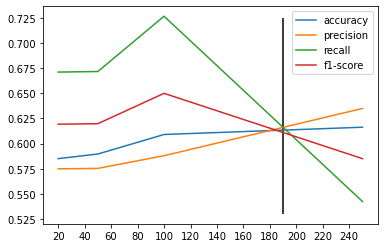

In [236]:
import matplotlib.pyplot as plt
x = [20,50,100,250]
plt.plot(x, accs)
plt.plot(x, precs)
plt.plot(x, recs)
plt.plot(x, f1s)
plt.legend(['accuracy','precision','recall','f1-score'])
plt.xticks(ticks=np.arange(0,260,20))
plt.vlines(190,ymin=0.53, ymax=0.725, color='black')
name = '../plots/'+'metrics_'+str(local_t_size)+'_dims_baseline.png'
plt.savefig(name, dpi=1000)
plt.show()


We note that the optimal number of dimensions seems to lie around **190** as the parameters are at their common highest at this point.